# Argon Plots

Plot hisogram of Argon sample depths

## Import packages

In [349]:
# general
import numpy as np
import pandas as pd
from tqdm import tqdm
import sys

# plotting
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Rectangle

# math
from scipy.stats import norm
from scipy.spatial import ConvexHull
from scipy.ndimage import gaussian_filter1d

# my own modules
sys.path.append("../core_scripts/")
from ECMclass import ECM, core_section

## User Inputs

In [398]:
# set file paths
path_to_figures = '../../figures/argon_plots/'
path_to_ecm = '../../data/ecm/alligned/'
path_to_angles = '../../data/angles/'
path_to_data = '../../data/'


# define the dip angles (currently hardcoded, should update to pull from .csv file)
theta_x = -39
theta_y = 14
#theta_x = 0
#theta_y = 0

## Read in the Data

In [399]:
## LOAD ANGLES DATA

# Load dip data
angles = pd.read_csv(path_to_angles + 'angles.csv')
angles.head()

,core,section,ACorDC,top_angle,left_angle,right_angle,side_angle,true_dip,true_dip_angles,true_dip_scores
0,alhic1901,228_4,AC,-36.776051,16.199769,-10.606322,13.403045,-38.643013,[-38.87808981 -38.54424142 -39.18075393 -37.73...,[0.88933205 0.97882252 0.95474921 0.95895482 0...
1,alhic1901,230_4,AC,27.819776,30.749623,-30.156336,30.452979,38.799076,[36.94242001 34.92239342 34.74296877 37.507310...,[0.99150915 0.99005042 0.99079277 0.99085791 0...


In [400]:
## LOAD ECM DATA

# Load metadata
meta = pd.read_csv(path_to_data + 'ecm/alligned/metadata.csv')
meta.head()

# set smoothing window
window = 10

# Load ECM data
data = []
cores = []
sections = []
faces = []
ACorDCs = []
for index, row in tqdm(meta.iterrows(), total=len(meta), desc="Processing data"):
    
    core = row['core']
        
    section = row['section']
    face = row['face']
    ACorDC = row['ACorDC']

    if ACorDC == 'AC' and face == 'o':

        data_item = ECM(core,section,face,ACorDC,path_to_data + 'ecm/alligned/')
        print("Reading "+core+", section "+section+'-'+face+'-'+ACorDC)
        
        data_item.rem_ends(1)
        data_item.smooth(window)
        data.append(data_item)
        
        cores.append(core)
        sections.append(section)
        faces.append(face)
        ACorDCs.append(ACorDC)
        

# Put ECM data into core_section structure
s228_4_AC = core_section('228_4','alhic1901','AC',data,sections,faces,cores,ACorDCs)

# place in 3D space
for s in [s228_4_AC]:
    s.add_3d_coords()

# add angles
for s in [s228_4_AC]:
    s.get_angles(angles)

Processing data:   0%|          | 0/14 [00:00<?, ?it/s]

Reading alhic1901, section 228_4-o-AC


Processing data: 100%|██████████| 14/14 [00:00<00:00, 39.23it/s]

No data found for top face of section 228_4 in core alhic1901
No data found for left face of section 228_4 in core alhic1901
No data found for right face of section 228_4 in core alhic1901
The 'top' face does not exist for this core section.
The 'left' face does not exist for this core section.
The 'right' face does not exist for this core section.


## Define Sections

Here we define the cuts, argon values, dip angles, etc

In [401]:
# set agon measurement values

Ar_age = [1369.1,1531.9,1676.8,1784.7,1656.1,1576.8]
names = ['1a','1b','2','3','4c','4d']


In [402]:
# Define the cut constraints as functions (inequalities)


# currently hardcoded for the shift - pulls from proccess_oppface.ipynb
overall_shift = 155.113

# set slopes
top_angle = theta_x
m = -np.tan(top_angle*np.pi/180)
l1 = 56 /1000
l2 = 163 /1000
ol1 = -95 /1000# was -80
ol2 = 115 /1000
l3 = -50 /1000
l4 = l2+125/1000

ol3 = 120 /1000
ol4 = 50 / 1000
l5 = 250 / 1000



c1a = [
    lambda pt: pt['x']**2 + pt['y']**2 <= (241/2/1000)**2,  # inside cylinder of radius 241/2
    lambda pt: pt['z'] < (m * pt['x'] + l1) + overall_shift, # 1
    lambda pt: pt['z'] > (-1/m * pt['x'] + ol1) + overall_shift,
    lambda pt: pt['z'] > (m * pt['x'] + l3) + overall_shift,
    lambda pt: pt['z'] > (-1/m * pt['x'] + ol3)+ overall_shift,
    lambda pt: pt['z'] < 155.235,
    lambda pt: pt['y'] > -.11,
    lambda pt: pt['y'] < -0.01,
]

c1b = [
    lambda pt: pt['x']**2 + pt['y']**2 <= (241/2/1000)**2,  # inside cylinder of radius 241/2
    lambda pt: pt['z'] < (m * pt['x'] + l1) + overall_shift, # 1
    lambda pt: pt['z'] > (-1/m * pt['x'] + ol1) + overall_shift,# 2
    lambda pt: pt['z'] > (m * pt['x'] + l3) + overall_shift, # 3
    lambda pt: pt['z'] < (-1/m * pt['x'] + ol3)+ overall_shift, # NEW
    lambda pt: pt['z'] < 155.18,
    lambda pt: pt['y'] > -.11,
    lambda pt: pt['y'] < -0.01,
]

c2 = [
    lambda pt: pt['x']**2 + pt['y']**2 <= (241/2/1000)**2,  # inside cylinder of radius 241/2
    lambda pt: pt['z'] > (m * pt['x'] + l1) + overall_shift, #1
    lambda pt: pt['z'] < (m * pt['x'] + l2) + overall_shift, #4
    lambda pt: pt['z'] > (-1/m * pt['x'] + ol1) + overall_shift, 
    #lambda pt: pt['z'] < (-1/m * pt['x'] + ol2) + overall_shift,
    lambda pt: pt['z'] < 155.23,
    lambda pt: pt['z'] > 155.14,
    lambda pt: pt['y'] < -0.01,
]

c3 = [
    lambda pt: pt['x']**2 + pt['y']**2 <= (241/2/1000)**2,  # inside cylinder of radius 241/2
    lambda pt: pt['z'] > (m * pt['x'] + l1) + overall_shift,
    lambda pt: pt['z'] < (m * pt['x'] + l2) + overall_shift,
    #lambda pt: pt['z'] > (-1/m * pt['x'] + ol2) + overall_shift,
    lambda pt: pt['z'] > 155.23,
    lambda pt: pt['y'] > -.11,
    lambda pt: pt['y'] < -0.01,
]

c4a = [
    lambda pt: pt['x']**2 + pt['y']**2 <= (241/2/1000)**2,  # inside cylinder of radius 241/2
    lambda pt: pt['z'] > (m * pt['x'] + l2) + overall_shift,
    lambda pt: pt['z'] > (-1/m * pt['x'] + ol1) + overall_shift,
    lambda pt: pt['z'] < (m * pt['x'] + l4) + overall_shift,
    lambda pt: pt['z'] > (-1/m * pt['x'] + ol4)+ overall_shift,
    lambda pt: pt['z'] < (m * pt['x'] + l5) + overall_shift,
    lambda pt: pt['y'] > -.11,
    lambda pt: pt['y'] < -0.01,
]

c4b = [
    lambda pt: pt['x']**2 + pt['y']**2 <= (241/2/1000)**2,  # inside cylinder of radius 241/2
    lambda pt: pt['z'] > (m * pt['x'] + l2) + overall_shift,
    lambda pt: pt['z'] > (-1/m * pt['x'] + ol1) + overall_shift,
    lambda pt: pt['z'] < (m * pt['x'] + l4) + overall_shift,
    lambda pt: pt['z'] < (-1/m * pt['x'] + ol4)+ overall_shift,
    lambda pt: pt['z'] < (m * pt['x'] + l5) + overall_shift,
    lambda pt: pt['y'] > -.11,
    lambda pt: pt['y'] < -0.01,
]

shapes = [c1a, c1b, c2, c3, c4a, c4b]

## Define Functions

In [403]:
def plot_ecm(axs,face,top_angle):

    cmap = matplotlib.colormaps['Spectral']

    res = 0.002

    meas = face.meas_s
    button = face.button_s
    ycor = face.y_s
    d = face.depth_s
    x_vector = face.x_3d
    y_vector = face.y_3d
    tracks = np.unique(x_vector)

    # define rescale
    pltmin = np.percentile(meas,5)
    pltmax = np.percentile(meas,95)
    rescale = lambda k: (k-pltmin) /  (pltmax-pltmin)

    # define width of track
    width = tracks[2] - tracks[1]

    for x in tracks:
        
        # Pull out data for this track
        idx = x_vector==x
        tmeas = meas[idx]
        tbut = button[idx]
        td = d[idx]

        # calculate the shift
        depth_shift = x * np.tan(top_angle * np.pi/180)
        td = td + depth_shift

        # downsample ECM to save plotting time (as needed)
        if res != 0:
            int_lo = round(min(td),2)
            int_hi = round(max(td),2)
            depth_interp = np.linspace(int_lo,int_hi,int((int_hi-int_lo)/res)+1)
            meas_interp = np.interp(depth_interp,np.flip(td),np.flip(tmeas))
            but_interp = np.interp(depth_interp,np.flip(td),np.flip(tbut))
            td = depth_interp
            tmeas = meas_interp
            tbut = np.round(but_interp)
        
        for i in range(len(tmeas)-1):
            
            if tbut[i] == 0:
                axs.add_patch(Rectangle((x-(width-0.001)/2,td[i]),(width-0.001),td[i+1]-td[i],facecolor=cmap(rescale(tmeas[i]))))
            else:
                axs.add_patch(Rectangle((x-(width-0.001)/2,td[i]),(width-0.001),td[i+1]-td[i],facecolor=cmap(rescale(tmeas[i]))))

    return pltmin, pltmax

## Identify the points which make up a sample

In [404]:
def get_points_in_sample(c,theta_x,theta_y):
    """
    Get points in the sample defined by the conditions in c.

    Parameters
    ----------
    c : list of callables
        Each should have signature cond(pt) -> bool array,
        where pt is a dict {'x': X, 'y': Y, 'z': Z}.

    Returns
    -------
    points : np.ndarray
        Array of points that satisfy all conditions.
    """

    # set number of samples
    N_samples = 1000000

    # set limits
    x_limits = (-241/2/1000, 241/2/1000)
    y_limits = (-241/2/1000,0)
    z_limits = (155.12, 155.30)
    
    # Sample candidate points uniformly from the bounding box
    x_samples = np.random.uniform(x_limits[0], x_limits[1], N_samples)
    y_samples = np.random.uniform(y_limits[0], y_limits[1], N_samples)
    z_samples = np.random.uniform(z_limits[0], z_limits[1], N_samples)
   
    # Pack into a structured array for easy constraint testing
    pts = np.zeros(N_samples, dtype=[('x', 'f8'), ('y', 'f8'), ('z', 'f8')])
    pts['x'], pts['y'], pts['z'] = x_samples, y_samples, z_samples

    # Test each candidate point against all constraints
    mask = np.ones(N_samples, dtype=bool)
    for fn in c:
        mask &= fn(pts)

    # Keep only the points inside the cube
    inside_x = pts['x'][mask]
    inside_y = pts['y'][mask]
    inside_z = pts['z'][mask]

    # apply shear transformation
    z_sheared = inside_z + inside_x * np.tan(np.deg2rad(theta_x)) + inside_y * np.tan(np.deg2rad(theta_y))
    #z_sheared = inside_z

    # return the points that are valid
    return inside_x, inside_y, z_sheared

textx, testy, testz = get_points_in_sample(shapes[0],theta_x,theta_y)

# Plot Sample Locations on ECM data

In [405]:
def plot_outlines(x, y, z, ax, color='black'):
    """
    Plot a smooth outline of the (x, z) projection of a set of points.

    Parameters
    ----------
    x : np.ndarray
        Array of x coordinates.
    y : np.ndarray
        Array of y coordinates (ignored).
    z : np.ndarray
        Array of z coordinates.
    ax : matplotlib.axes.Axes
        Axis to plot on.
    color : str
        Color for the outline (default 'black').
    """
    if len(x) == 0 or len(z) == 0:
        return

    # Stack x and z for 2D convex hull
    points_2d = np.column_stack((x, z))
    try:
        hull = ConvexHull(points_2d)
        outline = points_2d[hull.vertices]
        # Optionally smooth the outline for a "smooth shape"
        outline_x = outline[:, 0]
        outline_z = outline[:, 1]
        # Use gaussian_filter1d for smoothing
        smooth_x = gaussian_filter1d(outline_x, sigma=0.1, mode='wrap')
        smooth_z = gaussian_filter1d(outline_z, sigma=0.1, mode='wrap')
        ax.fill(smooth_x, smooth_z, color=color, alpha=0.1, linewidth=0)
        # Ensure the outline forms a closed loop
        if not (np.isclose(smooth_x[0], smooth_x[-1]) and np.isclose(smooth_z[0], smooth_z[-1])):
            smooth_x = np.append(smooth_x, smooth_x[0])
            smooth_z = np.append(smooth_z, smooth_z[0])
        ax.plot(smooth_x, smooth_z, color=color, linewidth=2)
    except Exception:
        # If convex hull fails (e.g., not enough points), skip plotting
        print("Convex hull failed, not enough points or degenerate case.")
        pass

## Plot hisogram of depths

In [419]:
# Plot Histogram Function

# Plot Histogram Function

def plot_depth_histogram(z_points, axis, color='blue', bins=50, smooth_sigma=2):
    """
    Plot a smoothed, normalized histogram (density curve) of depths (z_points)
    on the given axis so each curve has the same total area.
    """
    if len(z_points) == 0:
        return

    # get raw counts
    counts, bin_edges = np.histogram(z_points, bins=bins)
    # normalize by the total number of points
    counts = counts / counts.sum()
    # bin centers for plotting
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    # smooth the normalized counts
    smooth_counts = gaussian_filter1d(counts, sigma=smooth_sigma)

    axis.plot(smooth_counts, bin_centers, color=color, linewidth=2)


In [420]:
def plot_argon_and_depth(z_points, Ar_age, axis, color='blue', bins=50, smooth_sigma=2):
    
    Ar_thickness = 1000
    Ar_error = 55

    counts, bin_edges = np.histogram(z_points, bins=bins)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Smooth the histogram counts
    smooth_counts = gaussian_filter1d(counts, sigma=smooth_sigma)

    # represent the smoth_counts as a density curve from the Ar plot line
    density_curve = smooth_counts / np.sum(smooth_counts)  # Normalize to get density
    axis.fill_betweenx(bin_centers, Ar_age - Ar_thickness*density_curve, Ar_age + Ar_thickness*density_curve, color=color, alpha=0.2)

    # Add a solid line around the outside (ensure this starts a central point)
    # Make a vector that's bin_centers with the first and last values repeated twice
    y = np.concatenate(([bin_centers[0]], bin_centers, [bin_centers[-1]]))
    x = np.concatenate(([0], Ar_thickness*density_curve, [0]))
    axis.plot(Ar_age - x, y, color=color, linewidth=2)
    axis.plot(Ar_age + x, y, color=color, linewidth=2)

    # add a dot at the median
    median_depth = np.median(z_points)
    axis.plot(Ar_age, median_depth, 'o', color=color, markersize=8)

    # add horizontal error bar at the median depth
    axis.plot(
        [Ar_age - Ar_error, Ar_age + Ar_error],
        [median_depth, median_depth],
        color=color,
        linewidth=2
    )

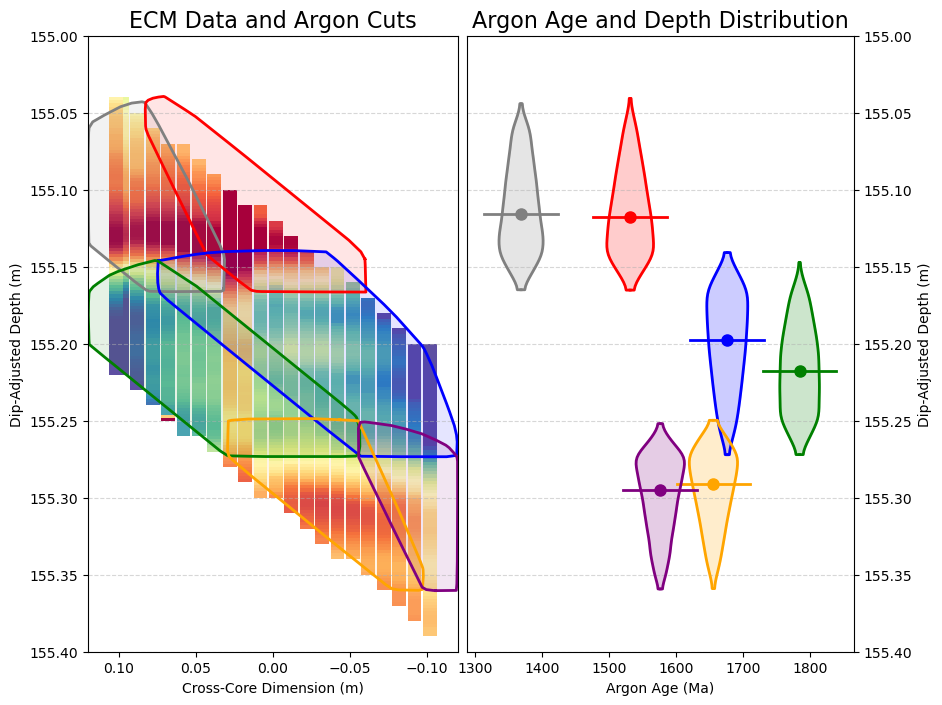

In [421]:
# Make figure
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])
ax = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]

# make a list of easily differentiated colors (at least 6)
colors = ['grey', 'red', 'blue', 'green', 'orange', 'purple']

# axis setup - yaxis
for a in ax:
     a.set_ylim([155.40,155.00])
for a in [ax[0],ax[-1]]:
    a.set_ylabel('Dip-Adjusted Depth (m)')

# set horizontal spacing to zero
fig.subplots_adjust(wspace=0.0)

# move right subplot labels to the right
ax[-1].yaxis.set_label_position("right")
ax[-1].yaxis.tick_right()

# xaxis setup
ax[0].set_xlim([.12,-.12])

# add ecm data to the first subplot
plot_ecm(ax[0],s228_4_AC.opposite,theta_x)
#plot_ecm(ax[0],s228_4_AC.opposite,0)

# add horizontal grid lines to all subplots
for a in ax:
    a.grid(axis='y', linestyle='--', alpha=0.5)

# titles
ax[0].set_title('ECM Data and Argon Cuts', fontsize=16)
ax[1].set_title('Argon Age and Depth Distribution', fontsize=16)

# x-axis labels
ax[0].set_xlabel('Cross-Core Dimension (m)')
ax[1].set_xlabel('Argon Age (Ma)')

# add outlines
for i, shape in enumerate(shapes):

    # assign color based on index
    color = colors[i % len(colors)]

    # get points in sample
    x, y, z = get_points_in_sample(shape, theta_x, theta_y)

    # plot the outline of the sample
    plot_outlines(x, y, z, ax[0], color=color)

    plot_argon_and_depth(z, Ar_age[i], ax[1], color=color, bins=50, smooth_sigma=2)

# set the aspect ratio to be equal
ax[0].set_aspect('equal')


## Make a plot for sketching out the cuts

[Text(0, 155.1, '155.10'),
 Text(0, 155.10999999999999, ''),
 Text(0, 155.11999999999998, ''),
 Text(0, 155.12999999999997, ''),
 Text(0, 155.13999999999996, ''),
 Text(0, 155.14999999999995, '155.15'),
 Text(0, 155.15999999999994, ''),
 Text(0, 155.16999999999993, ''),
 Text(0, 155.17999999999992, ''),
 Text(0, 155.1899999999999, ''),
 Text(0, 155.1999999999999, '155.20'),
 Text(0, 155.2099999999999, ''),
 Text(0, 155.21999999999989, ''),
 Text(0, 155.22999999999988, ''),
 Text(0, 155.23999999999987, ''),
 Text(0, 155.24999999999986, '155.25'),
 Text(0, 155.25999999999985, ''),
 Text(0, 155.26999999999984, ''),
 Text(0, 155.27999999999983, ''),
 Text(0, 155.28999999999982, ''),
 Text(0, 155.2999999999998, '155.30'),
 Text(0, 155.3099999999998, ''),
 Text(0, 155.3199999999998, ''),
 Text(0, 155.32999999999979, ''),
 Text(0, 155.33999999999978, '')]

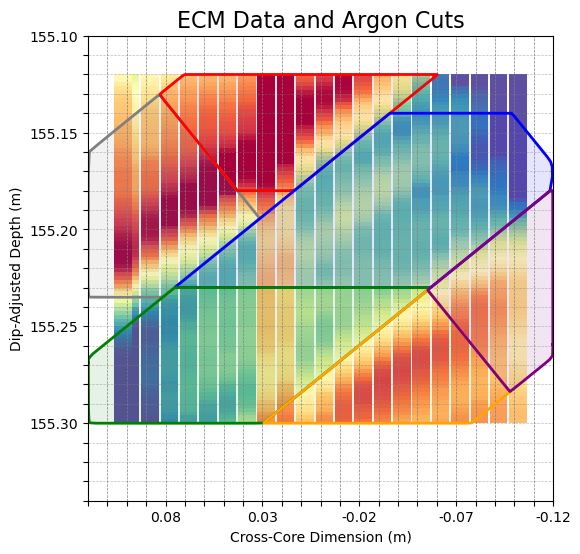

In [422]:
# Make figure
fig, ax = plt.subplots(figsize=(6, 9))



# make a list of easily differentiated colors (at least 6)
colors = ['grey', 'red', 'blue', 'green', 'orange', 'purple']

# axis setup - yaxis
ax.set_ylim([155.33,155.10])
ax.set_ylabel('Dip-Adjusted Depth (m)')

# axis setup - xaxis
ax.set_xlim([.12,-.12])

# add ecm data to the subplot
plot_ecm(ax, s228_4_AC.opposite, 0)

# add horizontal grid lines
ax.grid(axis='y', linestyle='--', alpha=0.5)

# title and x-axis label
ax.set_title('ECM Data and Argon Cuts', fontsize=16)
ax.set_xlabel('Cross-Core Dimension (m)')

# add outlines
for i, shape in enumerate(shapes):
    color = colors[i % len(colors)]
    x, y, z = get_points_in_sample(shape, 0, 0)
    plot_outlines(x, y, z, ax, color=color)

# set the aspect ratio to be equal
ax.set_aspect('equal', adjustable='box')

# add a 1cm by 1cm grid
# Set ticks every 0.01, but only label every 0.05
xticks = np.arange(-0.12, 0.13, 0.01)
yticks = np.arange(155.10, 155.34, 0.01)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.grid(which='both', linestyle='--', linewidth=0.5, color='gray')

# Only label every 5th tick (i.e., every 0.05)
ax.set_xticklabels([f"{tick:.2f}" if i % 5 == 0 else "" for i, tick in enumerate(xticks)])
ax.set_yticklabels([f"{tick:.2f}" if i % 5 == 0 else "" for i, tick in enumerate(yticks)])


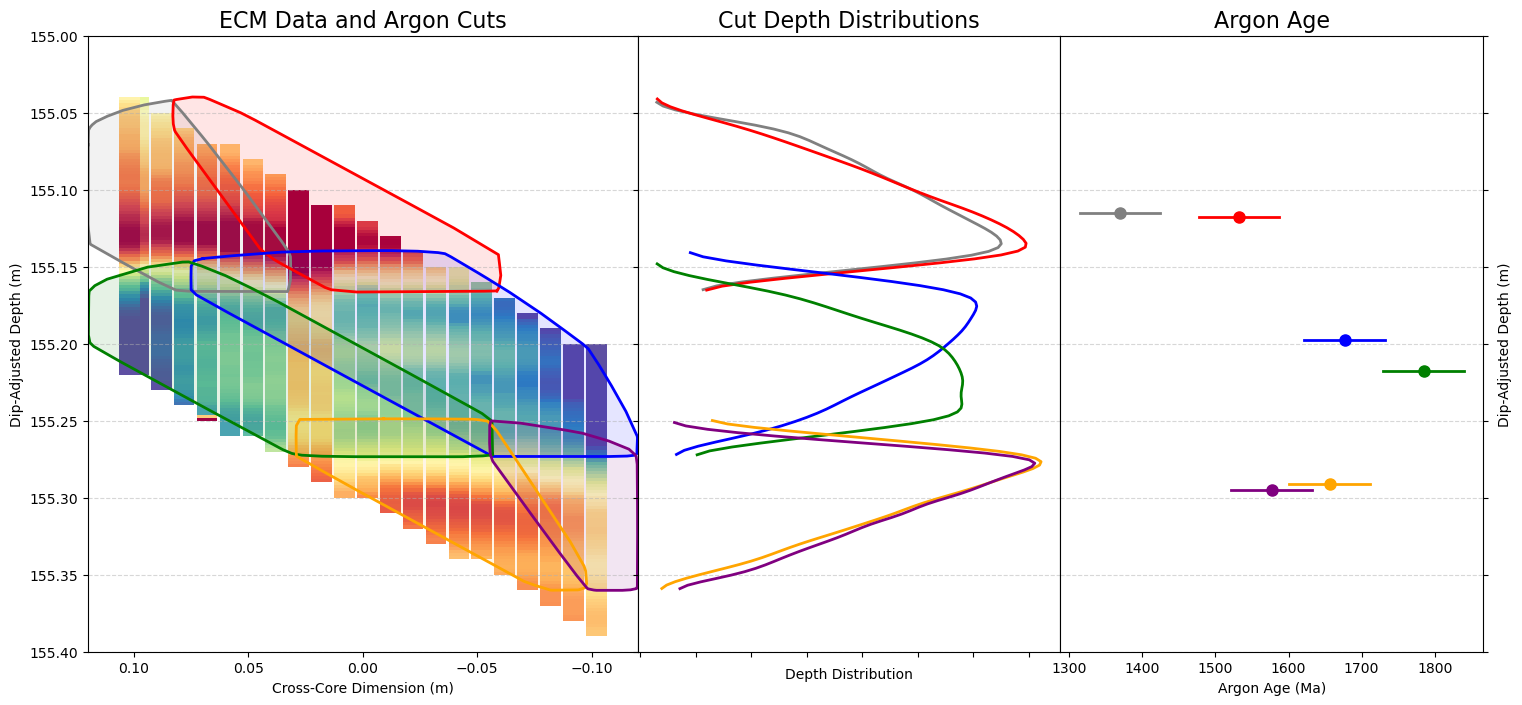

In [423]:
# Make figure
fig = plt.figure(figsize=(18, 8))
gs = fig.add_gridspec(1, 3, width_ratios=[1.3, 1, 1])
ax = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1]), fig.add_subplot(gs[2])]

# make a list of easily differentiated colors (at least 6)
colors = ['grey', 'red', 'blue', 'green', 'orange', 'purple']

# axis setup - yaxis
for a in ax:
     a.set_ylim([155.40,155.00])
for a in [ax[0],ax[-1]]:
    a.set_ylabel('Dip-Adjusted Depth (m)')

# set horizontal spacing to zero
fig.subplots_adjust(wspace=0.0)

# turn off ticks and labels on 2nd subplot y axis
ax[1].set_yticklabels([])
ax[2].set_yticklabels([])

# move right subplot labels to the right
ax[-1].yaxis.set_label_position("right")
ax[-1].yaxis.tick_right()

# xaxis setup
ax[0].set_xlim([.12,-.12])

# turn off ticks on ax[1] x axis
ax[1].set_xticklabels([])

# add ecm data to the first subplot
plot_ecm(ax[0],s228_4_AC.opposite,theta_x)
#plot_ecm(ax[0],s228_4_AC.opposite,0)

# add horizontal grid lines to all subplots
for a in ax:
    a.grid(axis='y', linestyle='--', alpha=0.5)

# titles
ax[0].set_title('ECM Data and Argon Cuts', fontsize=16)
ax[1].set_title('Cut Depth Distributions', fontsize=16)
ax[2].set_title('Argon Age', fontsize=16)
#ax[3].set_title('Argon Age and Depths', fontsize=16)

# x-axis labels
ax[0].set_xlabel('Cross-Core Dimension (m)')
ax[1].set_xlabel('Depth Distribution')
ax[2].set_xlabel('Argon Age (Ma)')
#ax[3].set_xlabel('Argon Age (Ma)')

# shade plots
# shade_valid_region(ax[0],c1,shade_color = 'grey',text='Cut 1')
# shade_valid_region(ax[0],c2,shade_color = 'red',text='Cut 2')
# shade_valid_region(ax[0],c3,shade_color = 'blue',text='Cut 3')
# shade_valid_region(ax[0],c4,shade_color = 'green',text='Cut 4')

# set Ar error
Ar_error = 55

# add outlines
for i, shape in enumerate(shapes):

    # assign color based on index
    color = colors[i % len(colors)]

    # get points in sample
    x, y, z = get_points_in_sample(shape, theta_x, theta_y)

    # plot the outline of the sample
    plot_outlines(x, y, z, ax[0], color=color)

    # plot the depth histogram
    plot_depth_histogram(z, ax[1], color=color, bins=50, smooth_sigma=2)

    # plot the argon age
    #ax[2].plot([Ar_age[i],Ar_age[i]],[min(z),max(z)],color=color,linewidth=2)

    # add a dot at the median argon age
    median_depth = np.median(z)
    ax[2].plot(Ar_age[i], median_depth, 'o', color=color, markersize=8)

    # add error bar at the median depth
    ax[2].plot(
        [Ar_age[i] - Ar_error, Ar_age[i] + Ar_error],
        [median_depth, median_depth],
        color=color,
        linewidth=2
    )   
